<a href="https://colab.research.google.com/github/mohAhanin/Alzheimer/blob/main/LSTM_Autoencoder_for_Anomaly_Detection_in_Aruba_Network_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The provided code snippet is a machine learning script that focuses on anomaly detection using an LSTM (Long Short-Term Memory) autoencoder model. Here’s a breakdown of what each part of the code does, and how it all fits together in the context of detecting anomalies in time-series data collected from sensors.

### Overview

The main goal of the script is to identify anomalies in time-series sensor data by reconstructing sequences of data points through an autoencoder model. Anomalies are detected by analyzing the reconstruction errors, which indicate how well the model can reconstruct the input data.

### Key Components of the Code

1. **Imports and Libraries**:
   - The code imports necessary libraries for data manipulation (`pandas`, `numpy`), machine learning (`sklearn`, `tensorflow.keras`), and visualization (`matplotlib`).

2. **Loading and Preprocessing Data**:
   - The `load_data` function reads a CSV file containing sensor data, processes it, and converts the 'Date' and 'Time' columns into a single `DateTime` column. This data is then limited to a specified number of rows.
   - **Example**:
     ```python
     normal_data = load_data(file_path='/content/drive/MyDrive/Copy of aruba.20100217-20240201_20240625.181859.txt')
     ```

3. **Creating Sequences**:
   - The `create_sequences` function generates overlapping sequences of a specified length (60 time steps in this case). This is essential for training the LSTM model, which expects input in a sequential format.

4. **Mounting Google Drive**:
   - The script mounts Google Drive to access the dataset stored in a Google Drive folder, allowing for seamless data importation.

5. **Preprocessing Data**:
   - The data is converted into a format suitable for machine learning by using one-hot encoding for categorical variables (`Sensor` and `State`) and dropping unnecessary columns (`DateTime`, `Time`, `Date`).

6. **Train-Test Split**:
   - The dataset is split into training and testing sets using `train_test_split` from `sklearn`. This helps in evaluating the performance of the model on unseen data.

7. **Building the LSTM Autoencoder Model**:
   - The model is constructed using the Sequential API from Keras. It consists of:
     - Two LSTM layers for encoding.
     - A `RepeatVector` layer to prepare the encoded representation for decoding.
     - Two LSTM layers for decoding.
     - A `TimeDistributed` layer with a dense output to reconstruct the input sequence.
   - **Example**:
     ```python
     model = Sequential([
         LSTM(100, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
         LSTM(50, activation='tanh', return_sequences=False),
         RepeatVector(X_train.shape[1]),
         LSTM(50, activation='tanh', return_sequences=True),
         LSTM(100, activation='tanh', return_sequences=True),
         TimeDistributed(Dense(X_train.shape[2]))
     ])
     ```

8. **Compiling the Model**:
   - The model is compiled using the Adam optimizer and mean squared error (MSE) as the loss function.

9. **Training the Model**:
   - The model is trained on the training data with early stopping to prevent overfitting. The training progress is monitored through validation loss.

10. **Evaluating the Model**:
    - After training, the model predicts the output for both training and testing data, and the reconstruction error is computed as the mean squared error between the original and predicted data.

11. **Setting a Threshold for Anomaly Detection**:
    - A threshold is determined based on the reconstruction errors from the training set, allowing the identification of anomalies in the testing set based on whether the reconstruction error exceeds this threshold.

12. **Identifying Anomalies**:
    - Anomalies are flagged where the reconstruction error is greater than the defined threshold.

13. **Printing Results**:
    - The number of detected anomalies and their indices are printed to the console.

14. **Plotting Reconstruction Error**:
    - A histogram of the reconstruction errors is plotted to visualize the distribution of errors and the threshold, helping to understand the performance of the anomaly detection.

### Example Output

- **Number of anomalies**: This line will tell you how many anomalies were detected in the test dataset.
- **Anomaly indices**: This line will provide the indices of the detected anomalies in the test set.
- **Histogram**: A graphical representation of the reconstruction errors, showing how the training and testing errors compare against the set threshold.

### Conclusion

This code provides a complete pipeline for anomaly detection in time-series data using LSTM autoencoders. It covers data loading, preprocessing, model training, evaluation, and anomaly detection, making it a robust approach for monitoring sensor data and identifying unusual patterns that may indicate problems or failures in a system.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess data
def load_data(file_path, num_rows=20000):
    data = pd.read_csv(file_path, sep='\s+', header=None,
                       names=['Date', 'Time', 'Sensor', 'State'])
    data = data.iloc[:num_rows,:]
    data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%Y-%m-%d %H:%M:%S.%f')
    return data

In [3]:
# Function to create sequences
def create_sequences(df, sequence_length=60):
    sequences = []
    for i in range(len(df) - sequence_length):
        # The 'DateTime' column is already removed, no need to drop it here.
        sequence = df.iloc[i:i+sequence_length].values
        sequences.append(sequence)
    return np.array(sequences)

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load normal data (after mounting)
normal_data = load_data(file_path='/content/drive/MyDrive/Copy of aruba.20100217-20240201_20240625.181859.txt') # Make sure this path is correct


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Combine and preprocess data
combined_data = pd.get_dummies(normal_data, columns=['Sensor', 'State'])
combined_data = combined_data.drop(columns=['DateTime', 'Time', 'Date'])

In [7]:
# Create sequences
X = create_sequences(combined_data)

In [10]:
# Train-test split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [11]:
# Convert data types
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [12]:
# Build the autoencoder model
model = Sequential([
    LSTM(100, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(50, activation='tanh', return_sequences=False),
    RepeatVector(X_train.shape[1]),
    LSTM(50, activation='tanh', return_sequences=True),
    LSTM(100, activation='tanh', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# Compile the model
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse')

In [14]:
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [15]:
# Train the model
history = model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0371 - val_loss: 0.0345
Epoch 2/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0344 - val_loss: 0.0342
Epoch 3/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0343 - val_loss: 0.0340
Epoch 4/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0341 - val_loss: 0.0338
Epoch 5/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0339 - val_loss: 0.0335
Epoch 6/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0335 - val_loss: 0.0331
Epoch 7/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0332 - val_loss: 0.0330
Epoch 8/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0330 - val_loss: 0.0328
Epoch 9/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0329 - val_loss: 0.0326
Epoch 10/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0327 - val_loss: 0.0324
Epoch 11/50
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0325 - val_loss: 0.0323
Epoch 12/50
399/399 ━━━━━━━━━━━━━━━━

In [16]:
# Evaluate the model
X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)

499/499 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [17]:
# Calculate reconstruction error
train_mse = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
test_mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

In [18]:
# Set a threshold for anomaly detection
threshold = np.percentile(train_mse, 95)

# Identify anomalies
anomalies = test_mse > threshold

# Print results
print(f'Number of anomalies: {np.sum(anomalies)}')
print(f'Anomaly indices: {np.where(anomalies)[0]}')


Number of anomalies: 7886
Anomaly indices: [   1    1    4 ... 3986 3987 3987]


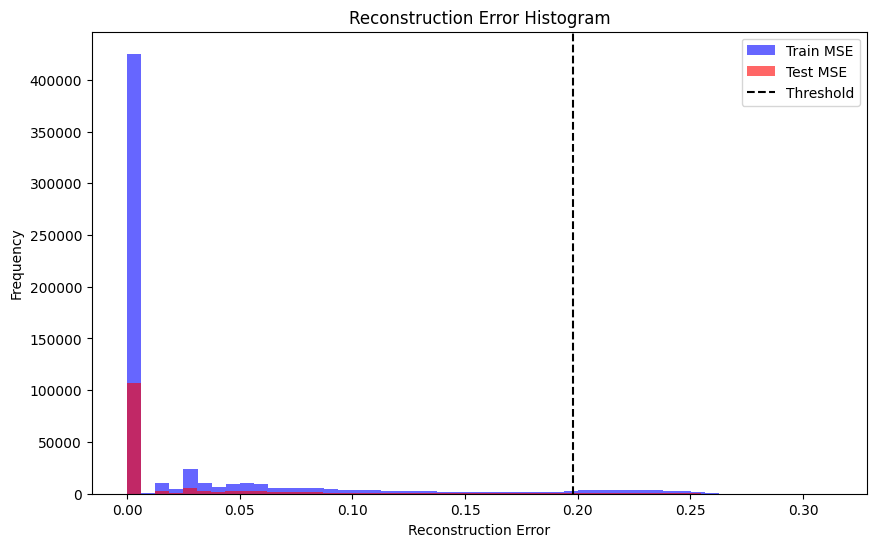

In [20]:
# Plot reconstruction error
plt.figure(figsize=(10, 6))
plt.hist(train_mse.flatten(), bins=50, alpha=0.6, color='b', label='Train MSE') # Flatten train_mse to a 1D array
plt.hist(test_mse.flatten(), bins=50, alpha=0.6, color='r', label='Test MSE') # Flatten test_mse to a 1D array
plt.axvline(threshold, color='k', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Reconstruction Error Histogram')
plt.show()